#### This notebook demonstrates the use of adversarial debiasing algorithm to learn a fair classifier.
Adversarial debiasing [1] is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary's ability to determine the protected attribute from the predictions. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit. We will see how to use this algorithm for learning models with and without fairness constraints and apply them on the Adult dataset.

In [2]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_german

from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import tensorflow as tf

C:\Users\anush\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\anush\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\anush\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\anush\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

#### Load dataset and set options

In [3]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_german()

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [4]:
# print(type(dataset_orig_train))

In [5]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(700, 11)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['sex', 'age']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


#### Metric for original training data

In [6]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.079064
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.066467


In [7]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())


#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.079064
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.066467


### Learn plan classifier without debiasing

In [8]:
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

In [9]:
plain_model.fit(dataset_orig_train)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




epoch 0; iter: 0; batch classifier loss: 0.774863
epoch 1; iter: 0; batch classifier loss: 0.691292
epoch 2; iter: 0; batch classifier loss: 0.652776
epoch 3; iter: 0; batch classifier loss: 0.612600
epoch 4; iter: 0; batch classifier loss: 0.652495
epoch 5; iter: 0; batch classifier loss: 0.632491
epoch 6; iter: 0; batch classifier loss: 0.559801
epoch 7; iter: 0; batch classifier loss: 0.569513
epoch 8; iter: 0; ba

In [10]:
# plain_model.fit(dataset_orig_train)

In [11]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [12]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.198519
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.136364


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.703333
Test set: Balanced classification accuracy = 0.540051
Test set: Disparate impact = 0.863636
Test set: Equal opportunity difference = -0.053571
Test set: Average odds difference = -0.167411
Test set: Theil_index = 0.067030


### Apply in-processing algorithm based on adversarial learning

In [13]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [14]:
# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

In [15]:
debiased_model.fit(dataset_orig_train)

epoch 0; iter: 0; batch classifier loss: 0.710919; batch adversarial loss: 0.747551
epoch 1; iter: 0; batch classifier loss: 0.696582; batch adversarial loss: 0.701836
epoch 2; iter: 0; batch classifier loss: 0.656561; batch adversarial loss: 0.810743
epoch 3; iter: 0; batch classifier loss: 0.643605; batch adversarial loss: 0.759975
epoch 4; iter: 0; batch classifier loss: 0.601287; batch adversarial loss: 0.740891
epoch 5; iter: 0; batch classifier loss: 0.595777; batch adversarial loss: 0.768069
epoch 6; iter: 0; batch classifier loss: 0.581032; batch adversarial loss: 0.772366
epoch 7; iter: 0; batch classifier loss: 0.608350; batch adversarial loss: 0.752409
epoch 8; iter: 0; batch classifier loss: 0.579062; batch adversarial loss: 0.808206
epoch 9; iter: 0; batch classifier loss: 0.619554; batch adversarial loss: 0.856523
epoch 10; iter: 0; batch classifier loss: 0.602977; batch adversarial loss: 0.802587
epoch 11; iter: 0; batch classifier loss: 0.570012; batch adversarial loss:

In [16]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [17]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())



display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.198519
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.136364


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.202703
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.136364


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.703333
Test set: Balanced classification accuracy = 0.540051
Test set: Disparate impact = 0.863636
Test set: Equal opportunity difference = -0.053571
Test set: Average odds difference = -0.167411
Test set: Theil_index = 0.067030


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.703333
Test set: Balanced classification accuracy = 0.540051
Test set: Disparate impact = 0.863636
Test set: Equal opportunity difference = -0.053571
Test set: Average odds difference = -0.167411
Test set: Theil_index = 0.067030



    References:
    [1] B. H. Zhang, B. Lemoine, and M. Mitchell, "Mitigating UnwantedBiases with Adversarial Learning," 
    AAAI/ACM Conference on Artificial Intelligence, Ethics, and Society, 2018.

In [18]:
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
FPR = classified_metric_debiasing_test.false_positive_rate()

print(TPR)
print(TNR)
print(FPR)

0.9853658536585366
0.09473684210526316
0.9052631578947369


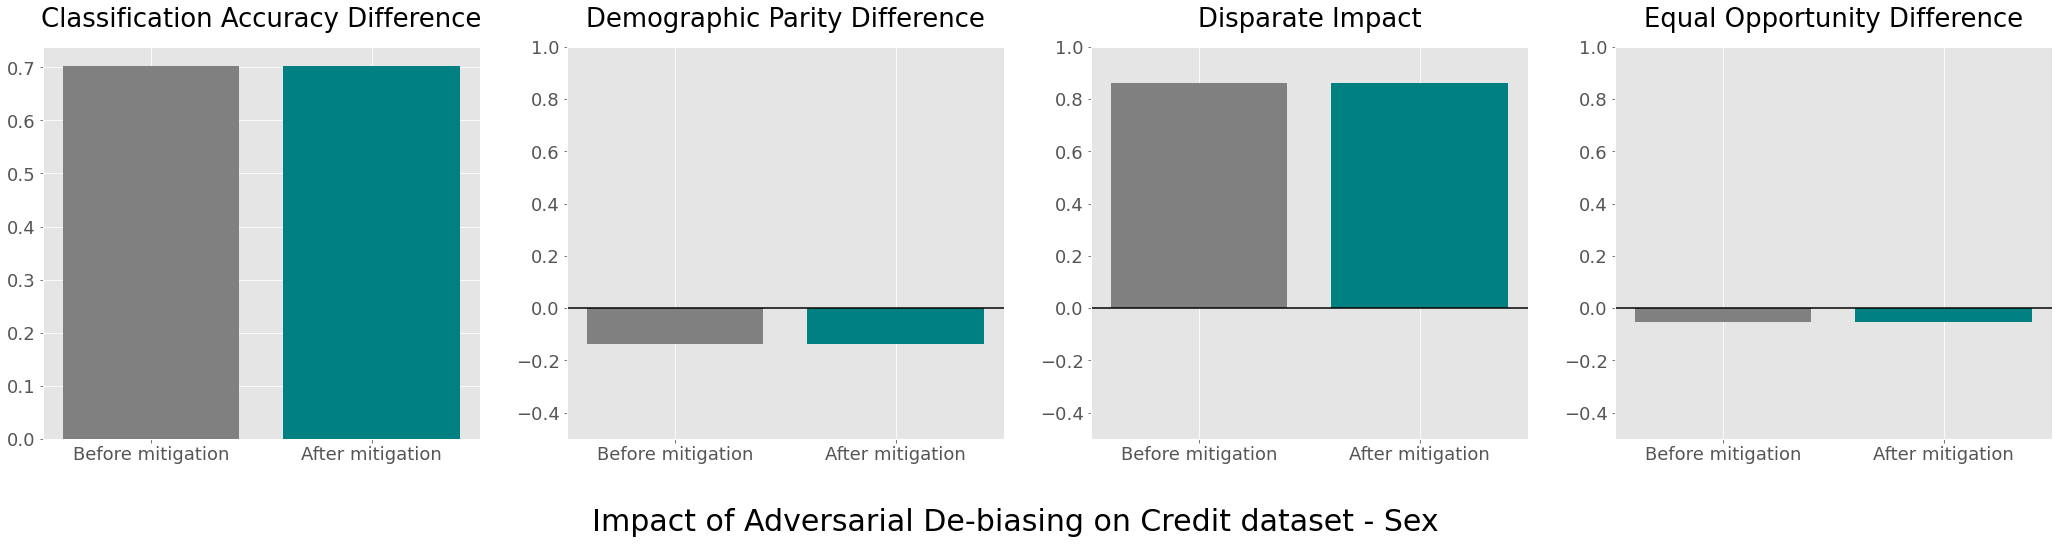

In [20]:
from common_utils import plot_metrics

plot_metrics(classified_metric_nodebiasing_test, classified_metric_debiasing_test, sensitive_attr='Sex', dataset='Credit')